## 1. Data Preparation

The purpose of the Titanic dataset is to predict whether the given passengers could be survived after Titinic hit the iceburg, according to their personal information.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

df_train_raw = pd.read_csv('../data/titanic/train.csv')
df_test_raw = pd.read_csv('../data/titanic/test.csv')
df_train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


Introduction of each field：

* Survived: 0 for death and 1 for survived [y labels]
* Pclass: Class of the tickets, with three possible values (1,2,3) [converting to one-hot encoding]
* Name: Name of each passenger [discarded]
* Sex: Gender of each passenger [converting to bool type]
* Age: Age of each passenger (partly missing) [numerical feature, should add "Whether age is missing" as auxiliary feature]
* SibSp: Number of siblings and spouse of each passenger (interger) [numerical feature]
* Parch: Number of parents/children of each passenger (interger) [numerical feature]
* Ticket: Ticket number (string) [discarded]
* Fare: Ticket price of each passenger (float, between 0 to 500) [numerical feature]
* Cabin: Cabin where each passenger is located (partly missing) [should add "Whether cabin is missing" as auxiliary feature]
* Embarked: Which port was each passenger embarked, possible values are S、C、Q (partly missing) [converting to one-hot encoding, four dimensions, S,C,Q,nan]

### EDA (Exploratory Data Analysis).
**Survival label distribution:**

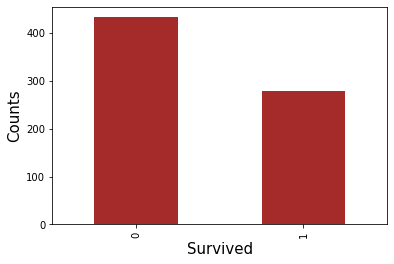

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = df_train_raw['Survived'].value_counts().plot(kind = 'bar', color='brown') # figsize=(8,5), fontsize=10, rot=0
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

**Age Distribution**

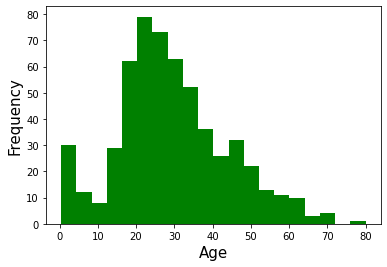

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = df_train_raw['Age'].plot(kind = 'hist',bins = 20, color= 'green') # figsize = (12,8),fontsize=15)
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

**Correlation between age and survival label**

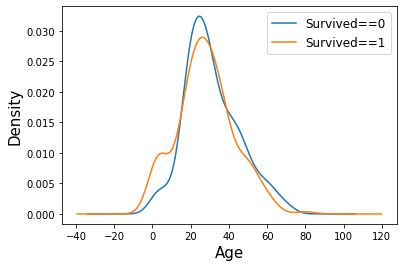

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = df_train_raw.query('Survived == 0')['Age'].plot(kind = 'density') # figsize = (12,8),fontsize=15)
df_train_raw.query('Survived == 1')['Age'].plot(kind = 'density')
ax.legend(['Survived==0','Survived==1'],fontsize = 12)

ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

**Formal Data Preprocessing**

In [39]:
def pre_processing(df_data):
    dfresult= pd.DataFrame()
    
    dfPclass = pd.get_dummies(df_data['Pclass'])
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult, dfPclass], axis = 1)
    
    dfSex = pd.get_dummies(df_data['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis = 1)
    
    dfresult['Age'] = df_data['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(df_data['Age']).astype('int32')
    
    dfresult['SibSp'] = df_data['SibSp']
    dfresult['Parch'] = df_data['Parch']
    dfresult['Fare'] = df_data['Fare']
    
    dfresult['Cabin_null'] =  pd.isna(df_data['Cabin']).astype('int32')
    
    dfEmbarked = pd.get_dummies(df_data['Embarked'], dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis = 1)
    
    return dfresult

x_train = pre_processing(df_train_raw)
y_train = df_train_raw['Survived'].values

x_test = pre_processing(df_test_raw)
y_test = df_test_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


In [37]:
pd.get_dummies(df_train_raw['Embarked'],dummy_na=True)

,C,Q,S,NaN
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
707,1,0,0,0
708,1,0,0,0
709,0,0,1,0
710,0,0,1,0


## Model Definition
**Usually there are three ways of modeling using APIs of Keras:**
1. sequential modeling using Sequential() function<br>
2. arbitrary modeling using functional API<br>
3. customized modeling by inheriting base class Model.

In [44]:
# Clear session
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(15,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


##  Model training

**There are three usual ways for model training:** 
1. use internal function fit<br>
2. use internal function train_on_batch<br>
3. customized training loop.

In [45]:
opt = tf.keras.optimizers.Adam()
# los = tf.keras.losses.binary_crossentropy()
met = tf.keras.metrics.AUC()

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[met])

history = model.fit(x_train, y_train,
                   batch_size=64, epochs=30,
                   validation_split=.2)

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 2ms/sample - loss: 2.9406 - auc: 0.5206 - val_loss: 2.5292 - val_auc: 0.5290
Epoch 2/30
569/569 [==============================] - 0s 94us/sample - loss: 2.2531 - auc: 0.5792 - val_loss: 2.0939 - val_auc: 0.5674
Epoch 3/30
569/569 [==============================] - 0s 126us/sample - loss: 1.8442 - auc: 0.6118 - val_loss: 1.8085 - val_auc: 0.6147
Epoch 4/30
569/569 [==============================] - 0s 102us/sample - loss: 1.5597 - auc: 0.6393 - val_loss: 1.5745 - val_auc: 0.6197
Epoch 5/30
569/569 [==============================] - 0s 148us/sample - loss: 1.3253 - auc: 0.6504 - val_loss: 1.3589 - val_auc: 0.6185
Epoch 6/30
569/569 [==============================] - 0s 146us/sample - loss: 1.1150 - auc: 0.6670 - val_loss: 1.1661 - val_auc: 0.6268
Epoch 7/30
569/569 [==============================] - 0s 239us/sample - loss: 0.9482 - auc: 0.6845 - val_loss: 1.0107 - val_auc: 0.6342
Epoch

## Model Evaluation
**evaluate the model performance on the training and validation datasets.**

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    print(history.history.keys())
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric, fontsize=15)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


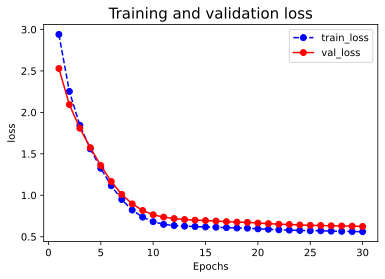

In [56]:
plot_metric(history, "loss")

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


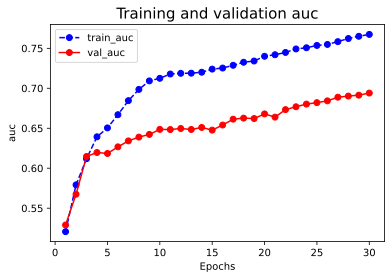

In [57]:
plot_metric(history, "auc")

**EVALUATE THE MODEL**

In [58]:
model.evaluate(x = x_test,y = y_test)

179/179 [==============================] - 0s 162us/sample - loss: 0.5590 - auc: 0.7529


[0.5590053383864504, 0.75287354]

## Model Application

In [61]:
#Predict the possiblities
model.predict(x_test[0:5])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #Identical way

array([[0.09106978],
       [0.38446626],
       [0.45996708],
       [0.7886587 ],
       [0.33368012]], dtype=float32)

In [62]:
#Predict the classes
model.predict_classes(x_test[0:5])

array([[0],
       [0],
       [0],
       [1],
       [0]])

## Model Saving
The trained model could be saved through either the way of Keras or the way of original TensorFlow. 
The former only allows using Python to retrieve the model, while the latter allows cross-platform deployment.

**Model Saving with Keras**

In [74]:
model.save('../data/keras_model.h5') 
del model  #Deleting current model

# Identical to the previous one
model = models.load_model('../data/keras_model.h5')
model.evaluate(x_test,y_test)

179/179 [==============================] - 0s 2ms/sample - loss: 0.5590 - auc: 0.7529


[0.5590053383864504, 0.75287354]

In [77]:
# Saving the model structure
json_str = model.to_json()

# Retrieving the model structure
model_json = models.model_from_json(json_str)

In [78]:
# Saving the weights of the model
model.save_weights('../data/keras_model_weight.h5')

# Retrieving the model structure
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# Load the weights
model_json.load_weights('../data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

179/179 [==============================] - 0s 2ms/sample - loss: 0.5590 - AUC: 0.7529


[0.5590053383864504, 0.75287354]

**Model Saving with Original Way of TensorFlow**

In [82]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('../data/tf_model_weights.ckpt',save_format = "tf")

# Saving model structure and parameters to a file, 
# so the model allows cross-platform deployment
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel\assets
export saved model.


In [81]:
model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

179/179 [==============================] - 0s 2ms/sample - loss: 0.5590 - auc: 0.7529


[0.5590051116224107, 0.75287354]